# 전략 Backtest
### Portfolio
* KOSDAQ 시장에 국한하여 전날 종가에 매수하여 익일 시가에 매도한다.

In [2]:
import pandas as pd

In [3]:
kosdaq_train = pd.read_excel('./datas/kosdaq_closing_quotation_strategy.xlsx').fillna(value=0.0) 

In [4]:
print(kosdaq_train.shape)
print('Index => ', kosdaq_train.index)
print('Column => ', kosdaq_train.columns)
kosdaq_train.head()

(4480, 5)
Index =>  RangeIndex(start=0, stop=4480, step=1)
Column =>  Index(['date', 'open', 'high', 'low', 'close'], dtype='object')


,date,open,high,low,close
0,1999/12/24,2608.9,2619.6,2491.7,2566.3
1,1999/12/27,2558.1,2680.1,2525.5,2564.5
2,1999/12/28,2543.6,2594.4,2529.2,2561.4
3,2000/01/04,2583.8,2682.6,2528.5,2660.0
4,2000/01/05,2561.6,2635.8,2532.3,2629.5


In [25]:
kosdaq_train['date'] = pd.to_datetime(kosdaq_train['date'])

In [26]:
kosdaq_train.head()

,date,open,high,low,close
0,1999-12-24,2608.9,2619.6,2491.7,2566.3
1,1999-12-27,2558.1,2680.1,2525.5,2564.5
2,1999-12-28,2543.6,2594.4,2529.2,2561.4
3,2000-01-04,2583.8,2682.6,2528.5,2660.0
4,2000-01-05,2561.6,2635.8,2532.3,2629.5


### 코스닥 그래프

In [13]:
%matplotlib inline
# import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datetime as dt
import numpy as np

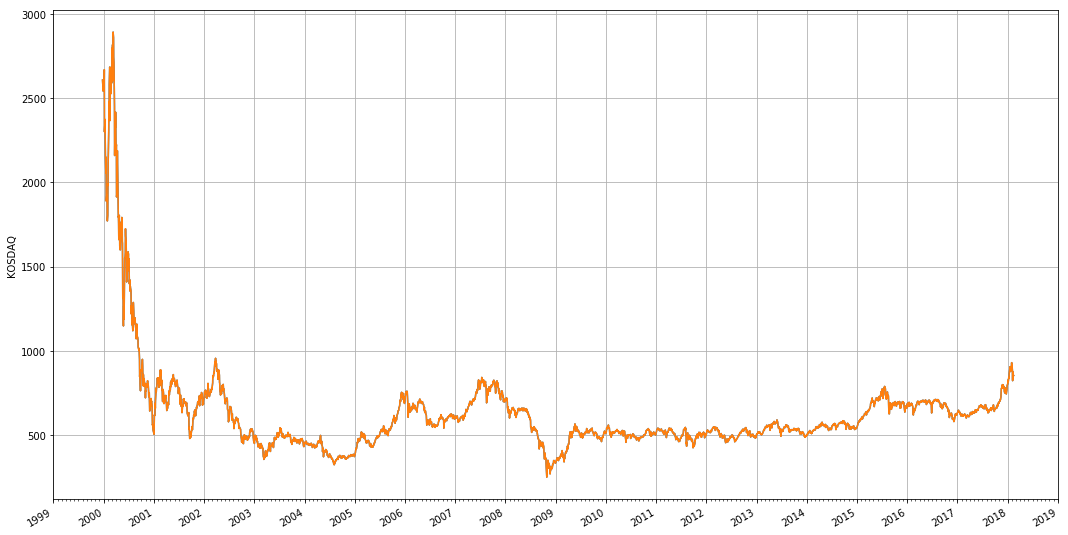

In [51]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 10)
ax.plot(kosdaq_train.date, kosdaq_train.open)

# format the ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years...
datemin = np.datetime64(kosdaq_train.date[0], 'Y')
datemax = np.datetime64(kosdaq_train.iloc[-1].date, 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

ax.plot(kosdaq_train['date'], kosdaq_train['open'])

ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
figure.autofmt_xdate()

plt.ylabel('KOSDAQ')

plt.show()

In [62]:
transaction_cost = 0.01

In [63]:
def daily_earning_ratio(df, transaction_cost):
    df['close-open'] = 0.0
    for idx in range(1, len(df.index)):
        df.loc[idx:idx+1, 'earning(d)'] = df.iloc[idx]['open']*(1-transaction_cost) / df.iloc[idx-1]['close']*(1-transaction_cost)

In [65]:
daily_earning_ratio(kosdaq_train, transaction_cost)

kosdaq_train.head()

,date,open,high,low,close,earning(d)
0,1999-12-24,2608.9,2619.6,2491.7,2566.3,0.000000
1,1999-12-27,2558.1,2680.1,2525.5,2564.5,0.976968
2,1999-12-28,2543.6,2594.4,2529.2,2561.4,0.972112
3,2000-01-04,2583.8,2682.6,2528.5,2660.0,0.988671
4,2000-01-05,2561.6,2635.8,2532.3,2629.5,0.943844


In [42]:
kosdaq_train.iloc[-1].date

Timestamp('2018-02-13 00:00:00')